In [3]:
!git clone https://github.com/minimario/gtsrb


Cloning into 'gtsrb'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 52027 (delta 34), reused 71 (delta 17), pack-reused 51939
Receiving objects: 100% (52027/52027), 363.45 MiB | 28.19 MiB/s, done.
Resolving deltas: 100% (209/209), done.
Checking out files: 100% (51922/51922), done.


In [25]:
np.random.seed(1234)
np.random.normal(0, 1, (3,))

array([ 0.47143516, -1.19097569,  1.43270697])

In [32]:
from keras.models import load_model
model = load_model('gtsrb/model_small_92.h5')
print(model.summary())
# 16
# 32

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 8)         224       
_________________________________________________________________
activation_8 (Activation)    (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 8)         584       
_________________________________________________________________
activation_9 (Activation)    (None, 48, 48, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 16)       

In [29]:
!pwd
%cd gtsrb/CNN-Cert

/content/gtsrb/CNN-Cert
[Errno 2] No such file or directory: 'gtsrb/CNN-Cert'
/content/gtsrb/CNN-Cert


In [34]:
import numpy as np
import keras
from keras.models import load_model
from load_images import X, Y
from cnn_bounds_full import Model, run_gtsrb

# model = load_model("../model_clast.h5")
# cnn_model = Model(model, inp_shape=(48, 48, 3))

# load the model
model = load_model("../model_small_92.h5")

channels = 16
cam_dim = 24



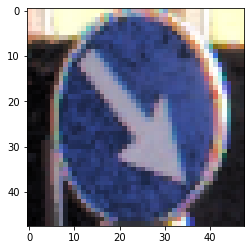

Predicted:  38
Actual:  38


In [36]:
from matplotlib import pyplot as plt
image = X[19]
plt.imshow(image)
plt.show()
print("Predicted: ", np.argmax(model.predict(X[19:19+1])))
print("Actual: ", np.argmax(Y[19]))

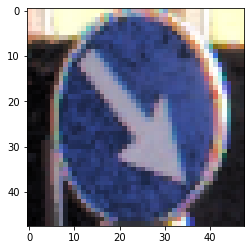

In [24]:
from load_images import X, Y
plt.imshow(X[19])
plt.show()

In [ ]:

# 1) calculate the CAM
def get_cam_map(model, image, target_class):
    fc_weights = model.weights[-2].numpy()  # channels x 43
    last_conv_layer_output_model = keras.Model(  # model to get the last conv layer outputs
        model.input, model.get_layer(index=-3).output
    )
    last_conv_layer_output = last_conv_layer_output_model(
        np.expand_dims(image, 0)
    )  # last conv layer output
    cam_map = np.zeros((cam_dim, cam_dim))
    for channel in range(channels):
        cam_map += (
            last_conv_layer_output[0, :, :, channel].numpy()
            * fc_weights[channel, target_class]
        )  # weighted sum of last conv layers
    return cam_map


# 2) calculate the top k indices of the CAM
def get_maximum_indices(array, num_indices):
    sorted_r, sorted_c = np.unravel_index(np.argsort(-array, axis=None), array.shape)
    topk_r, topk_c = sorted_r[:num_indices], sorted_c[:num_indices]
    not_topk_r, not_topk_c = sorted_r[num_indices:], sorted_c[num_indices:]
    return ((topk_r, topk_c), (not_topk_r, not_topk_c))


def get_cam_top_k(cam_map, k):
    return get_maximum_indices(cam_map, k)


# 3) calculate the bounds for the CAM and some given epsilon
def calculate_cam_bounds(model, cnn_model, image, eps):
    # make sure predicted class is correct
    pred_class = np.argmax(model.predict(np.expand_dims(image, axis=0)))
    # print("Pred: {}, Correct: {}".format(pred_class, correct_class))

    # get the LB's and UB's for the CAM
    LBs, UBs = run_gtsrb(cnn_model, image, correct_class, eps, 105)
    last_conv_lb = LBs[-3]  # (cam_dim, cam_dim, channels)
    last_conv_ub = UBs[-3]
    fc_weights = model.weights[-2].numpy()  # channels x 43

    cam_LB = np.zeros((cam_dim, cam_dim))
    cam_UB = np.zeros((cam_dim, cam_dim))

    for channel in range(channels):
        channel_weight = fc_weights[channel, pred_class]
        if channel_weight < 0:
            cam_LB += last_conv_ub[:, :, channel] * channel_weight
            cam_UB += last_conv_lb[:, :, channel] * channel_weight
        else:
            cam_LB += last_conv_lb[:, :, channel] * channel_weight
            cam_UB += last_conv_ub[:, :, channel] * channel_weight

    return cam_LB, cam_UB


def check_top_k(cam_map, cam_LB, cam_UB, num_indices):
    (topk_r, topk_c), (not_topk_r, not_topk_c) = get_cam_top_k(cam_map, num_indices)
    min_LB_top_k = np.min(
        cam_LB[topk_r, topk_c]
    )  # minimum lower bound of top k indices
    max_UB_not_top_k = np.max(
        cam_UB[not_topk_r, not_topk_c]
    )  # maximum upper bound of indices not in top k
    return min_LB_top_k > max_UB_not_top_k

def check_top_k_close(cam_map, cam_LB, cam_UB, k1, k2):
    (topk_r, topk_c), (not_topk_r, not_topk_c) = get_cam_top_k(cam_map, k1)
    not_top_k_values = cam_UB[not_topk_r, not_topk_c]
    top_k_necessary = np.partition(-not_top_k_values, k2-k1)[k2-k1]

    not_top_k_values.sort()
    not_top_k_values = np.flip(not_top_k_values)
    assert(-top_k_necessary == not_top_k_values[k2-k1])
    min_LB_top_k = np.min(cam_LB[topk_r, topk_c])
    return min_LB_top_k > -top_k_necessary


def get_interpretability_bound(model, image, num_indices):
    correct_class = np.argmax(model.predict(image[np.newaxis, :]))
    cam_map = get_cam_map(model, image, correct_class)
    cnn_model = Model(model, inp_shape=(48, 48, 3))

    eps_min = 0
    eps_max = 0.05
    num_iterations = 15
    for it in range(num_iterations):
        print("Iteration {}, LB: {}, UB: {}".format(it, eps_min, eps_max))
        eps_mid = (eps_min + eps_max) / 2
        cam_LB, cam_UB = calculate_cam_bounds(model, cnn_model, image, eps_mid)
        if check_top_k(cam_map, cam_LB, cam_UB, num_indices):
            eps_min = eps_mid
        else:
            eps_max = eps_mid

    return eps_min

def get_interpretability_bound_rank(model, image, k1, k2):
    correct_class = np.argmax(model.predict(image[np.newaxis, :]))
    cam_map = get_cam_map(model, image, correct_class)
    cnn_model = Model(model, inp_shape=(48, 48, 3))

    eps_min = 0
    eps_max = 0.05
    num_iterations = 15
    for it in range(num_iterations):
        print("Iteration {}, LB: {}, UB: {}".format(it, eps_min, eps_max))
        eps_mid = (eps_min + eps_max) / 2
        cam_LB, cam_UB = calculate_cam_bounds(model, cnn_model, image, eps_mid)
        if check_top_k_close(cam_map, cam_LB, cam_UB, k1, k2):
            eps_min = eps_mid
        else:
            eps_max = eps_mid

    return eps_min

In [1]:

# bound = get_interpretability_bound(model, image, 15)

# xs = []
# perts = []
# for i in range(18, 100, 5):
#   xs.append(i)
#   bound2 = get_interpretability_bound_rank(model, image, 18, i)
#   perts.append(bound2)
#   print(perts)
import pickle
data = {}
with open('data_19.pkl', 'wb') as f:
    pickle.dump(data, f)

def run(top_k):
    with open('data_19.pkl', 'rb') as f:
        data = pickle.load(f)
    if top_k not in data:
        bound = get_interpretability_bound(model, image, top_k)
        data[top_k] = bound
    with open('data_19.pkl', 'wb') as f:
        pickle.dump(data, f)

for i in [1, 2, 3, 4, 5, 10, 15, 18, 20, 30, 50]:
  run(i)

NameError: ignored

In [ ]:
bound = get_interpretability_bound_rank(model, image, 15, 15)

(48, 48, 3)
conv
(48, 48, 8)
activation
(48, 48, 8)
conv
(48, 48, 8)
activation
(48, 48, 8)
pool
(24, 24, 8)
dropout
(24, 24, 8)
conv
(24, 24, 16)
activation
(24, 24, 16)
conv
(24, 24, 16)
activation
(24, 24, 16)
global avg pool
(1, 1, 16)
FC
(1, 1, 43)
Iteration 0, LB: 0, UB: 0.05
Pred: 12, Correct: 12


KeyboardInterrupt: ignored

In [ ]:

import pickle
data = {}
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

for top_k in range(1, 11):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    if top_k not in data:
        bound = get_interpretability_bound(model, image, top_k)
        data[top_k] = bound
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f)


(48, 48, 3)
conv
(48, 48, 8)
activation
(48, 48, 8)
conv
(48, 48, 8)
activation
(48, 48, 8)
pool
(24, 24, 8)
dropout
(24, 24, 8)
conv
(24, 24, 16)
activation
(24, 24, 16)
conv
(24, 24, 16)
activation
(24, 24, 16)
global avg pool
(1, 1, 16)
FC
(1, 1, 43)
Iteration 0, LB: 0, UB: 0.05
Pred: 12, Correct: 12


/content/gtsrb/CNN-Cert/cnn_bounds_full.py:531: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, A))
  u - inner_stride[1] * q,
/content/gtsrb/CNN-Cert/cnn_bounds_full.py:537: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 1d, C))
  B_new[x, y, :] += np.dot(A[x, y, :, p, q, :], b)


KeyboardInterrupt: ignored